In [1]:
#| export

import tempfile
from pathlib import Path
from random import randrange, choice, sample
from typing import List, Any
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from infobip_service.download import raw_data_path

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44305,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:34631,Total threads: 8
Dashboard: http://127.0.0.1:37921/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:33365,


# Dataset preparation

Train/Validation prep:

1. Split into train/validation by PersonId (80/20)
2. Max time to max() of dataframe - 56
3. Min time to min() of dataframe
4. apply sample_user_histories to train and validation

Test prep:

2. Max time to max() of dataframe - 28
3. Min time to min() of dataframe
4. apply sample_user_histories to train and validation

In [3]:
#| export

processed_data_path = Path() / '..' / 'data' / 'processed'

In [4]:
processed_data_path.mkdir(parents=True, exist_ok=True)

In [5]:
def write_and_read_parquet(df: pd.DataFrame, *, path: Path, **kwargs) -> pd.DataFrame:
    df.to_parquet(path, **kwargs)
    return dd.read_parquet(path, calculate_divisions=True)

In [6]:
raw_data = dd.read_parquet(raw_data_path)
raw_data.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


## Time tresholding

In [7]:
def _sample_time_map(df: pd.DataFrame, *, time_treshold: datetime) -> pd.DataFrame:
    df = df[df['OccurredTime'] < time_treshold]
    return df

In [8]:
raw = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-12 13:27:02.370368",
            "2023-07-12 13:27:03.493824",
            "2023-07-12 13:27:04.617280",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two", "three"],
        "ApplicationId": [None, None, None, None, None, None],
    }, index=pd.Index([1, 2, 2, 3, 3, 3], name="PersonId"))
raw["OccurredTime"] = pd.to_datetime(raw["OccurredTime"])
raw["DefinitionId"] = raw["DefinitionId"].astype("string[pyarrow]")
raw["ApplicationId"] = raw["ApplicationId"].astype("string[pyarrow]")


expected = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "three"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 2, 3], name="PersonId"))
expected["OccurredTime"] = pd.to_datetime(expected["OccurredTime"])
expected["DefinitionId"] = expected["DefinitionId"].astype("string[pyarrow]")
expected["ApplicationId"] = expected["ApplicationId"].astype("string[pyarrow]")

In [9]:
pd.testing.assert_frame_equal(_sample_time_map(raw, time_treshold=datetime(2023, 7, 11)), expected)

In [10]:
#| export

def sample_time_map(ddf: dd.DataFrame, *, time_treshold: datetime) -> dd.DataFrame:
    meta = _sample_time_map(ddf._meta, time_treshold=time_treshold)
    return ddf.map_partitions(_sample_time_map, time_treshold=time_treshold, meta=meta)

In [11]:
actual = sample_time_map(dd.from_pandas(raw, npartitions=2), time_treshold=datetime(2023, 7, 11)).compute()
pd.testing.assert_frame_equal(actual, expected)

### Dataset time exploration

In [12]:
time_stats = raw_data["OccurredTime"].describe().compute()
time_stats

count                         27999602
min                2023-03-29 12:59:30
25%                2023-06-15 10:01:10
50%                2023-10-17 13:10:22
75%      2023-11-28 08:59:49.321999872
max         2023-12-23 00:00:30.906000
Name: OccurredTime, dtype: string

In [13]:
# | export

# Time treshold is 28 days before for test horizon
max_time = datetime.strptime(time_stats["max"], "%Y-%m-%d %H:%M:%S.%f")
time_treshold = max_time - timedelta(days=28)
time_treshold

datetime.datetime(2023, 11, 25, 0, 0, 30, 906000)

In [14]:
time_cutoff_data = sample_time_map(raw_data, time_treshold=time_treshold)
time_cutoff_data = write_and_read_parquet(time_cutoff_data, path=processed_data_path / 'time_cutoff_data.parquet')
time_cutoff_data.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


In [15]:
def _remove_without_history(df: pd.DataFrame, *, time_treshold: datetime) -> pd.DataFrame:
    indexes_with_history = df[df['OccurredTime'] < time_treshold].index
    return df[df.index.isin(indexes_with_history)]

df = pd.DataFrame({
    'OccurredTime': ['2022-01-01 10:00:00', '2022-01-01 11:00:00', '2022-01-01 12:00:00'],
    'Data': [1, 2, 3]
})
df["OccurredTime"] = pd.to_datetime(df["OccurredTime"])


time_threshold = datetime.strptime('2022-01-01 11:30:00', '%Y-%m-%d %H:%M:%S')

result = _remove_without_history(df, time_treshold=time_threshold)

expected = pd.DataFrame({
    'OccurredTime': ['2022-01-01 10:00:00', '2022-01-01 11:00:00'],
    'Data': [1, 2]
}, index=[0, 1])
expected["OccurredTime"] = pd.to_datetime(expected["OccurredTime"])

assert result.equals(expected)

In [16]:
# Remove everyone that does not have history before the train/validation horizon

def remove_without_history(ddf: dd.DataFrame, *, time_treshold: datetime) -> dd.DataFrame:
    meta = _remove_without_history(ddf._meta, time_treshold=time_treshold)
    return ddf.map_partitions(_remove_without_history, time_treshold=time_treshold, meta=meta)

data_before_horizon = remove_without_history(time_cutoff_data, time_treshold=time_treshold - timedelta(days=28))
data_before_horizon = write_and_read_parquet(data_before_horizon, path=processed_data_path / 'data_before_horizon.parquet')
data_before_horizon.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


/tmp/ipykernel_1497258/3128690863.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(factor).apply(lambda x: x.count()).plot(kind='bar', rot=45, legend=0);


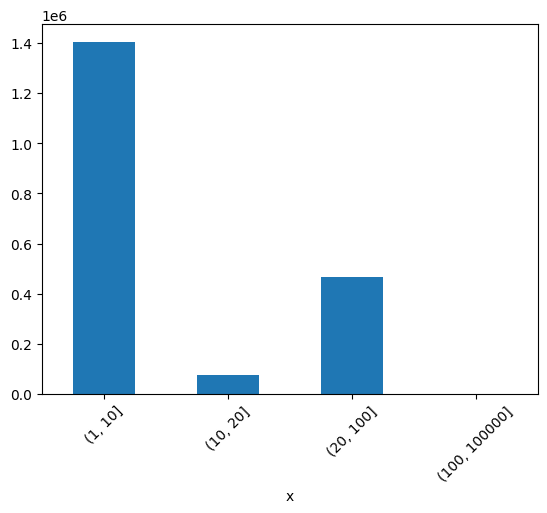

In [17]:
df = pd.DataFrame({'x':data_before_horizon.index.value_counts().compute().values})
factor = pd.cut(df.x, [1,10,20,100,100000])
df.groupby(factor).apply(lambda x: x.count()).plot(kind='bar', rot=45, legend=0);

## Train/test split

In [18]:
def split_data(ddf: dd.DataFrame, *, split_ratio: float = 0.8) -> (dd.DataFrame, dd.DataFrame):
    # ddf = ddf.set_index(ddf.index, sorted=True)
    user_index = ddf.index.unique().compute()
    train_index = np.random.choice(user_index, size=int(len(user_index)*split_ratio), replace=False)
    validation_index = np.setdiff1d(user_index, train_index)

    train_data = ddf.loc[train_index]
    validation_data = ddf.loc[validation_index]

    return train_data, validation_data

In [19]:
user_histories = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
            "2023-07-13 13:27:01.246912",
            "2023-07-26 13:27:05.740736",
            "2023-07-26 13:27:05.740736",

        ],
        "DefinitionId": ["one", "one", "one", "two", "two", "three"],
        "ApplicationId": [None, None, None, None, None, None],
    }, index=pd.Index([1, 1, 2, 2, 3, 3], name="PersonId"))

user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories_ddf = dd.from_pandas(user_histories, npartitions=5)
user_histories_ddf

,AccountId,OccurredTime,DefinitionId,ApplicationId
npartitions=3,,,,
1,string,datetime64[ns],string,string
2,...,...,...,...
3,...,...,...,...
3,...,...,...,...


In [20]:
with tempfile.TemporaryDirectory() as tmpdirname:
    train, validation = split_data(user_histories_ddf, split_ratio=0.7)
    
    train = write_and_read_parquet(train, path = tmpdirname + "/train")
    validation = write_and_read_parquet(validation, path = tmpdirname + "/validation")

    assert train.npartitions == 2
    assert validation.npartitions == 1

    assert len(train.index.unique().compute()) == 2
    assert len(validation.index.unique().compute()) == 1

In [21]:
train_raw, validation_raw = split_data(data_before_horizon, split_ratio=0.8)

train_raw = write_and_read_parquet(train_raw, path=processed_data_path / "train_raw.parquet")
validation_raw = write_and_read_parquet(validation_raw, path=processed_data_path / "validation_raw.parquet")

/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 37.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


# Sample construction

## Next event

In [22]:
def _get_next_event(df: pd.DataFrame, *, t0: datetime) -> pd.DataFrame:
    _df = df[df['OccurredTime'] >= t0]
    return pd.DataFrame({
        "AccountId": [_df["AccountId"].values[0] if len(_df) > 0 else None],
        "DefinitionId": [_df["DefinitionId"].values[0] if len(_df) > 0 else None],
        "ApplicationId": [_df["ApplicationId"].values[0] if len(_df) > 0 else None],
        "OccurredTime": [_df["OccurredTime"].values[0] if len(_df) > 0 else None],
    }, index=pd.Index(['NextEvent'])).T

In [23]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [24]:
_get_next_event(user_history, t0=datetime(2023, 7, 19))
_get_next_event(user_history, t0=datetime(2023, 7, 29))

,NextEvent
AccountId,None
DefinitionId,None
ApplicationId,None
OccurredTime,None


In [25]:
def get_next_event(df: pd.DataFrame, *, t0: datetime) -> pd.DataFrame:
    return df.groupby("PersonId").apply(lambda x: _get_next_event(x, t0=t0))

In [26]:
get_next_event(user_history, t0=datetime(2023, 7, 19))
get_next_event(user_history, t0=datetime(2023, 7, 29))

NextEvent
PersonId                        
1        AccountId          None
         DefinitionId       None
         ApplicationId      None
         OccurredTime       None

## History construction

In [27]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [28]:
#| export
def pad_left(l: list, *, size: int) -> list:
    return np.pad(l, pad_width=(size-len(l),0), mode='empty')


def _create_user_history(user_history: pd.DataFrame, *, t0: datetime, history_size: int) -> pd.DataFrame:
    user_history = user_history[user_history['OccurredTime'] < t0]
    user_history = user_history.sort_values(by='OccurredTime', ascending=False)
    user_history = user_history.head(history_size)
    user_history = user_history.sort_values(by='OccurredTime')

    reconstructed_history = pd.DataFrame({
        "AccountId": pad_left(user_history["AccountId"].values, size=history_size),
        "DefinitionId": pad_left(user_history["DefinitionId"].values, size=history_size),
        "ApplicationId": pad_left(user_history["ApplicationId"].values, size=history_size),
        "OccurredTime": pad_left(user_history["OccurredTime"].values, size=history_size),
    }, index=pd.Index([f"h_{i}" for i in range(history_size)], name="HistoryId")).T

    return reconstructed_history

In [29]:
_create_user_history(user_history, t0=datetime(2023, 7, 13), history_size=3)

HistoryId,h_0,h_1,h_2
AccountId,1688995620123456000,12345,12345
DefinitionId,None,one,one
ApplicationId,None,None,None
OccurredTime,1970-01-01 00:00:00,2023-07-10 13:27:00.123456,2023-07-12 13:27:01.246912


In [30]:
user_histories = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
            "2023-07-13 13:27:01.246912",
            "2023-07-26 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two"],
        "ApplicationId": [None, None, None, None, None],
    }, index=pd.Index([1, 1, 1, 2, 2], name="PersonId"))
user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories

,AccountId,OccurredTime,DefinitionId,ApplicationId
PersonId,,,,
1,12345,2023-07-10 13:27:00.123456,one,None
1,12345,2023-07-12 13:27:01.246912,one,None
1,12345,2023-07-28 13:27:05.740736,one,None
2,12345,2023-07-13 13:27:01.246912,two,None
2,12345,2023-07-26 13:27:05.740736,two,None


In [31]:
# | export

def create_user_histories(user_histories: pd.DataFrame, *, t0: datetime, history_size: int) -> pd.DataFrame:
        try:
                return user_histories.groupby("PersonId").apply(lambda x: _create_user_history(x, t0=t0, history_size=history_size))
        except KeyError:
                print(user_histories)

In [32]:
create_user_histories(user_histories, t0=datetime(2023, 7, 16), history_size=2)

HistoryId                                         h_0  \
PersonId                                                
1        AccountId                              12345   
         DefinitionId                             one   
         ApplicationId                           None   
         OccurredTime      2023-07-10 13:27:00.123456   
2        AccountId                               None   
         DefinitionId                            None   
         ApplicationId                           None   
         OccurredTime   1970-01-01 00:00:00.000000001   

HistoryId                                      h_1  
PersonId                                            
1        AccountId                           12345  
         DefinitionId                          one  
         ApplicationId                        None  
         OccurredTime   2023-07-12 13:27:01.246912  
2        AccountId                           12345  
         DefinitionId                          two  
         ApplicationId                        None  
         OccurredTime   2023-07-13 13:27:01.246912

In [33]:
user_history = pd.DataFrame({
        "AccountId": [12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
        ],
        "DefinitionId": ["one"],
        "ApplicationId": [None],
    }, index=pd.Index([1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

create_user_histories(user_histories, t0=datetime(2023, 7, 16), history_size=2)

HistoryId                                         h_0  \
PersonId                                                
1        AccountId                              12345   
         DefinitionId                             one   
         ApplicationId                           None   
         OccurredTime      2023-07-10 13:27:00.123456   
2        AccountId                               None   
         DefinitionId                            None   
         ApplicationId                           None   
         OccurredTime   1970-01-01 00:00:00.000000001   

HistoryId                                      h_1  
PersonId                                            
1        AccountId                           12345  
         DefinitionId                          one  
         ApplicationId                        None  
         OccurredTime   2023-07-12 13:27:01.246912  
2        AccountId                           12345  
         DefinitionId                          two  
         ApplicationId                        None  
         OccurredTime   2023-07-13 13:27:01.246912

## Dataset sampling

In [34]:
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [35]:
assert datetime(2023, 7, 10) < random_date(datetime(2023, 7, 10), datetime(2023, 7, 28)) < datetime(2023, 7, 28)

In [36]:
def convert_datetime(time: str) -> datetime:
    try:
        return datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        return datetime.strptime(time, "%Y-%m-%d %H:%M:%S.%f")

In [40]:
def sample_user_histories(user_histories: pd.DataFrame, *, min_time: datetime, max_time: datetime, history_size: int) -> pd.DataFrame:    
    num_samples_to_go = len(user_histories) // history_size + 1


    max_time = min(user_histories["OccurredTime"].describe()["max"] + timedelta(days=1), max_time)
    min_time = max(user_histories["OccurredTime"].describe()["min"], min_time)

    user_histories_sample = None

    timestamp_misses = 0

    while num_samples_to_go > 0:
        t0 = random_date(min_time, max_time)
        filtered_index = user_histories[user_histories['OccurredTime'] < t0].index.unique()
        if len(filtered_index) == 0:
            timestamp_misses += 1
            continue
        
        chosen_user_history = user_histories[user_histories.index.isin([choice(filtered_index)])]
        
        next_event_timedelta = get_next_event(chosen_user_history, t0=t0)
        reconstructed_history = create_user_histories(chosen_user_history, t0=t0, history_size=history_size)
        reconstructed_history = pd.merge(reconstructed_history, next_event_timedelta, left_index=True, right_index=True)
        reconstructed_history.index = reconstructed_history.index.map(lambda x: (f'{x[0]}_{t0}', x[1]))

        if user_histories_sample is None:
            user_histories_sample = reconstructed_history
        else:
            user_histories_sample = pd.concat([user_histories_sample, reconstructed_history])
        
        num_samples_to_go -= 1
    
    print(f"Timestamp misses: {timestamp_misses}, missed ratio: {(timestamp_misses / (len(user_histories)+timestamp_misses))*100:.2f}%")

    return user_histories_sample

In [41]:
# može se patchat random date ovdje za test

user_histories_sample = sample_user_histories(user_histories, min_time=datetime(2023, 7, 9) , max_time=datetime(2023, 7, 20), history_size=2)
user_histories_sample

Timestamp misses: 0, missed ratio: 0.00%


h_0  \
PersonId                                                                    
2_2023-07-18 03:59:23.123456 AccountId                               None   
                             DefinitionId                            None   
                             ApplicationId                           None   
                             OccurredTime   1970-01-01 00:00:00.000000001   
2_2023-07-18 01:57:25.123456 AccountId                               None   
                             DefinitionId                            None   
                             ApplicationId                           None   
                             OccurredTime   1970-01-01 00:00:00.000000001   
1_2023-07-16 16:55:16.123456 AccountId                              12345   
                             DefinitionId                             one   
                             ApplicationId                           None   
                             OccurredTime      2023-07-10 13:27:00.123456   

                                                                   h_1  \
PersonId                                                                 
2_2023-07-18 03:59:23.123456 AccountId                           12345   
                             DefinitionId                          two   
                             ApplicationId                        None   
                             OccurredTime   2023-07-13 13:27:01.246912   
2_2023-07-18 01:57:25.123456 AccountId                           12345   
                             DefinitionId                          two   
                             ApplicationId                        None   
                             OccurredTime   2023-07-13 13:27:01.246912   
1_2023-07-16 16:55:16.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        None   
                             OccurredTime   2023-07-12 13:27:01.246912   

                                                             NextEvent  
PersonId                                                                
2_2023-07-18 03:59:23.123456 AccountId                           12345  
                             DefinitionId                          two  
                             ApplicationId                        None  
                             OccurredTime   2023-07-26 13:27:05.740736  
2_2023-07-18 01:57:25.123456 AccountId                           12345  
                             DefinitionId                          two  
                             ApplicationId                        None  
                             OccurredTime   2023-07-26 13:27:05.740736  
1_2023-07-16 16:55:16.123456 AccountId                           12345  
                             DefinitionId                          one  
                             ApplicationId                        None  
                             OccurredTime   2023-07-28 13:27:05.740736

In [42]:
user_histories_sample = sample_user_histories(user_history, min_time=datetime(2023, 7, 9) , max_time=datetime(2023, 7, 20), history_size=2)
user_histories_sample

Timestamp misses: 0, missed ratio: 0.00%


h_0  \
PersonId                                                                    
1_2023-07-11 12:25:02.123456 AccountId                                  1   
                             DefinitionId                            None   
                             ApplicationId                           None   
                             OccurredTime   1970-01-01 00:00:00.000000001   

                                                                   h_1  \
PersonId                                                                 
1_2023-07-11 12:25:02.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        None   
                             OccurredTime   2023-07-10 13:27:00.123456   

                                           NextEvent  
PersonId                                              
1_2023-07-11 12:25:02.123456 AccountId          None  
                             DefinitionId       None  
                             ApplicationId      None  
                             OccurredTime       None

In [43]:
def prepare_data(ddf: dd.DataFrame, *, min_time: datetime, max_time: datetime, history_size: int) -> pd.DataFrame:
    meta = sample_user_histories(ddf.head(2, npartitions=-1), min_time=min_time, max_time=max_time, history_size=history_size)    

    sampled_data = ddf.map_partitions(sample_user_histories, min_time=min_time, max_time=max_time, history_size=history_size, meta=meta)

    return sampled_data

In [44]:
user_histories = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
            "2023-07-13 13:27:01.246912",
            "2023-07-26 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two"],
        "ApplicationId": [None, None, None, None, None],
    }, index=pd.Index([1, 1, 2, 2, 2], name="PersonId"))

user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories_ddf = dd.from_pandas(user_histories, npartitions=2)
user_histories_ddf

,AccountId,OccurredTime,DefinitionId,ApplicationId
npartitions=2,,,,
1,string,datetime64[ns],string,string
2,...,...,...,...
2,...,...,...,...


In [45]:
user_index = user_histories_ddf.index.unique().compute()
train_index = np.random.choice(user_index, size=1, replace=False)
validation_index = np.setdiff1d(user_index, train_index)

max_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["max"], "%Y-%m-%d %H:%M:%S.%f")
min_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["min"], "%Y-%m-%d %H:%M:%S.%f")

sampled_data = prepare_data(user_histories_ddf, history_size=8, min_time=min_time, max_time=max_time)

display(sampled_data.head(4, npartitions=-1))

Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%


h_0  \
PersonId                                                                    
1_2023-07-12 18:27:51.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 14:55:40.809708948   

                                                            h_1  \
PersonId                                                          
1_2023-07-12 18:27:51.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                                      h_2  \
PersonId                                                                    
1_2023-07-12 18:27:51.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 14:55:32.165677176   

                                                                      h_3  \
PersonId                                                                    
1_2023-07-12 18:27:51.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 14:55:31.428223968   

                                                                      h_4  \
PersonId                                                                    
1_2023-07-12 18:27:51.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 14:55:31.428223952   

                                                                      h_5  \
PersonId                                                                    
1_2023-07-12 18:27:51.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-01 00:00:00.053114576   

                                                                   h_6  \
PersonId                                                                 
1_2023-07-12 18:27:51.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-10 13:27:00.123456   

                                                                   h_7  \
PersonId                                                                 
1_2023-07-12 18:27:51.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-12 13:27:01.246912   

                                           NextEvent  
PersonId                                              
1_2023-07-12 18:27:51.123456 AccountId          <NA>  
                             DefinitionId       <NA>  
                             ApplicationId      <NA>  
                             OccurredTime       <NA>

In [46]:
user_histories = pd.DataFrame({
        "AccountId": [12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
        ],
        "DefinitionId": ["two"],
        "ApplicationId": [None],
    }, index=pd.Index([1], name="PersonId"))

user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories_ddf = dd.from_pandas(user_histories, npartitions=2)
user_histories_ddf

user_index = user_histories_ddf.index.unique().compute()
train_index = np.random.choice(user_index, size=1, replace=False)
validation_index = np.setdiff1d(user_index, train_index)

max_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["max"], "%Y-%m-%d %H:%M:%S.%f") + timedelta(days=1)
min_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["min"], "%Y-%m-%d %H:%M:%S.%f") - timedelta(days=1)

sampled_data = prepare_data(user_histories_ddf, history_size=8, min_time=min_time, max_time=max_time)

display(sampled_data.head(4, npartitions=-1))

/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%


h_0  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 15:02:54.981906947   

                                                            h_1  \
PersonId                                                          
1_2023-07-10 20:28:21.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                                      h_2  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 15:03:12.503124088   

                                                                      h_3  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 15:03:10.721349168   

                                                                      h_4  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-02 15:03:10.721349152   

                                                                      h_5  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-01 00:00:00.046527248   

                                                                      h_6  \
PersonId                                                                    
1_2023-07-10 20:28:21.123456 AccountId                               <NA>   
                             DefinitionId                            <NA>   
                             ApplicationId                           <NA>   
                             OccurredTime   1970-01-01 00:00:00.046527232   

                                                                   h_7  \
PersonId                                                                 
1_2023-07-10 20:28:21.123456 AccountId                           12345   
                             DefinitionId                          two   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-10 13:27:00.123456   

                                           NextEvent  
PersonId                                              
1_2023-07-10 20:28:21.123456 AccountId          <NA>  
                             DefinitionId       <NA>  
                             ApplicationId      <NA>  
                             OccurredTime       <NA>

## Prepare real data

In [47]:
def prepare_ddf(ddf: dd.DataFrame, *, history_size: int) -> dd.DataFrame:
    max_time = convert_datetime(ddf["OccurredTime"].describe().compute()["max"]) - timedelta(days=28)
    min_time = convert_datetime(ddf["OccurredTime"].describe().compute()["min"])

    sampled_data = prepare_data(ddf, history_size=history_size, min_time=min_time, max_time=max_time)

    return sampled_data

In [48]:
train_prepared = write_and_read_parquet(prepare_ddf(train_raw, history_size=64), path=processed_data_path / "train_prepared.parquet")

train_prepared.head()

Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses

2024-01-17 15:43:13,592 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8788', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
  File "/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%


h_0  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_1  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_2  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_3  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_4  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_5  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_6  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_7  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                                                         h_8  \
PersonId                  level_1                              
6360_2023-07-01 01:29:06  AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
12494_2023-03-31 21:45:16 AccountId                        0   

                

In [49]:
validation_prepared = write_and_read_parquet(prepare_ddf(validation_raw, history_size=64), path=processed_data_path / "validation_prepared.parquet")

validation_prepared.head()

Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses: 0, missed ratio: 0.00%
Timestamp misses

h_0  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_1  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_2  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_3  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_4  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_5  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_6  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_7  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                                                         h_8  \
PersonId                  level_1                              
15202_2023-08-07 05:12:49 AccountId                        0   
                          DefinitionId                  <NA>   
                          ApplicationId                 <NA>   
                          OccurredTime   1970-01-01 00:00:00   
542_2023-07-23 23:50:52   AccountId                        0   

                

In [ ]:
client.close()
assert False, "Stop here"

## Time to next Event buckets

In [ ]:
# | export

timedelta_buckets = [timedelta(days=days) for days in [1, 3, 7, 14, 28]]

def _bin_timedelta(timedelta: timedelta, *, timedelta_buckets: List[timedelta]=timedelta_buckets):
    for class_value, timedelta_key in enumerate(timedelta_buckets):
        if timedelta < timedelta_key:
            return class_value

    return len(timedelta_buckets)

In [ ]:
assert _bin_timedelta(timedelta(days=0)) == 0
assert _bin_timedelta(timedelta(days=2)) == 1
assert _bin_timedelta(timedelta(days=4)) == 2
assert _bin_timedelta(timedelta(days=8)) == 3
assert _bin_timedelta(timedelta(days=16)) == 4
assert _bin_timedelta(timedelta(days=32)) == 5

In [ ]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [ ]:
#| export

def bin_next_event_user_history(user_history: pd.DataFrame, *, t0: datetime, timedelta_buckets: List[timedelta]=timedelta_buckets):
    user_history = user_history[user_history['OccurredTime'] > t0]
    if user_history.empty:
        return len(timedelta_buckets)

    return _bin_timedelta(user_history['OccurredTime'].min() - t0, timedelta_buckets=timedelta_buckets)

In [ ]:
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 10)) == 0 # 1 day to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 9)) == 1 # 2 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 6, 1)) == 5 # >28 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 20)) == 3 # 8 days to last event (t0 in the middle of events)